In [9]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [10]:
# Overall settings
out_dir = "out"


current_path = os.getcwd().split("in-context-bldc")[0]
data_path = os.path.join(current_path,"in-context-bldc", "data")

folder = "CL_experiments_double_sensor_low_speed_ekf_and_meta/"
folder_path = os.path.join(data_path, folder)

model_name = "ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2.pt"

folder_path_final = folder_path + "final/"
folder_path_final_fixed = folder_path + "final_fixed/"

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])
print(exp_data["cfg"].lr)

True
10
4931
0.00044166864245198667
Namespace(model_dir='out', out_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', in_file='ckpt_50pct_recursive_h10_real_val_speed_correction_low_speed_v2', init_from='scratch', seed=42, log_wandb=False, nx=4, nu=5, ny=1, seq_len=10, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=128, max_iters=8000, warmup_iters=5000, lr=1e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=10, lr_decay_iters=8000, min_lr=1.0000000000000002e-06, decay_lr=True, eval_batch_size=128)
1e-05


In [11]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)
H = exp_data["cfg"].seq_len
batch_size = 32



number of parameters: 0.03M


In [12]:
folder_list = glob.glob(os.path.join(folder_path_final, "*"))

cpu_time_avgs = []
cpu_time_stds = []

for file_idx in range(len(folder_list)):
    csv_list = glob.glob(os.path.join(folder_list[file_idx], "*.csv"))

    dfs = load_dataframes_from_folder(folder_list[file_idx])
    print(f"Loaded {len(dfs)} DataFrames from {folder_list[file_idx]}.") 
    dataset_exp = Dataset(dfs=dfs, seq_len=H)
    dataloader = DataLoader(dataset_exp, batch_size=batch_size)

    df_len = len(dfs)
    rmse = np.zeros(df_len)
    u_full_all = []
    y_full_all = []
    for i in range(df_len):
        u_full, y_full = dataset_exp.get_full_experiment(i)
        u_full, y_full = u_full.to(device), y_full.to(device)
        u_full_all.append(u_full)
        y_full_all.append(y_full)

    u_full_all = torch.stack(u_full_all, dim=0)
    y_full_all = torch.stack(y_full_all, dim=0)
    y_pred_all = torch.zeros_like(y_full_all)
    last_omega = torch.zeros((df_len, H, 1)) 

    cpu_time =  [] 

    with torch.no_grad():
        for j in range(y_full_all.shape[1]):

            start = time.time()
            
            # at time instant j
            if j < H:
                input_val = u_full_all[:, :j+1, :]
                input_val[:, :j+1, 4] = last_omega[:,-j-1:,0]
                pred = model(input_val)[:,-1,:]
            else:
                input_val = u_full_all[:,j-H+1:j+1, :]
                input_val[:,:, 4] = last_omega[:,:,0]
                pred = model(input_val)[:,-1,:]
            
            y_pred_all[:,j,0] = pred[:,0]
            last_omega = torch.roll(last_omega, -1, 1)
            last_omega[:,-1,0] = y_pred_all[:,j,0]
            cpu_time.append((time.time()-start))
        
        u_full_all, y_full_all, y_pred_all  = reverse_normalization(u_full_all, y_full_all, y_pred_all)
    
    cpu_time_avgs.append(np.mean(cpu_time))
    cpu_time_stds.append(np.std(cpu_time))
        
    for i in range(df_len):
        y_tmp = y_full_all[i,:,:].cpu().numpy()
        y_pred_tmp = y_pred_all[i,:,:].cpu().numpy()

        df = pd.read_csv(csv_list[i])
        # df.to_csv(csv_list[i])
        df["omega_meta"] = y_pred_tmp
        rmse[i] = np.sqrt(((y_tmp-y_pred_tmp)**2).mean())

    print("Average rmse: ", rmse.mean())


print("average cpu time: ", np.mean(cpu_time_avgs))
print("std cpu time: ", np.mean(cpu_time_stds))







Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\inertia05_ki-0.0029-kp-3.0000.
Average rmse:  34.81443557739258
Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\inertia07_ki-0.0029-kp-3.0000.
Average rmse:  44.525853093465166
Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\inertia09_ki-0.0029-kp-3.0000.
Average rmse:  40.765188217163086
Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\inertia11_ki-0.0029-kp-3.0000.
Average rmse:  43.16288134256999
Loaded 15 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final\inertia13_ki-0.0029-kp-3.0000.
Average rmse:  34.61573053

In [13]:
print(cpu_time_avgs)

[0.0037622755086189072, 0.0034932691581895923, 0.0035137564742743887, 0.003790810453734686, 0.003533659713585666, 0.003754760611333505]


Loaded 1 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed\inertia05_ki-0.0029-kp-3.0000.
Average rmse:  28.49518394470215
Loaded 1 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed\inertia07_ki-0.0029-kp-3.0000.
Average rmse:  45.3160285949707
Loaded 1 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed\inertia09_ki-0.0029-kp-3.0000.
Average rmse:  34.31618118286133
Loaded 1 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed\inertia11_ki-0.0029-kp-3.0000.
Average rmse:  31.1319637298584
Loaded 1 DataFrames from c:\Users\39340\Documents\GitHub\in-context-bldc\data\CL_experiments_double_sensor_low_speed_ekf_and_meta/final_fixed\inertia13_ki-0.0029-kp-3.0000.
Avera

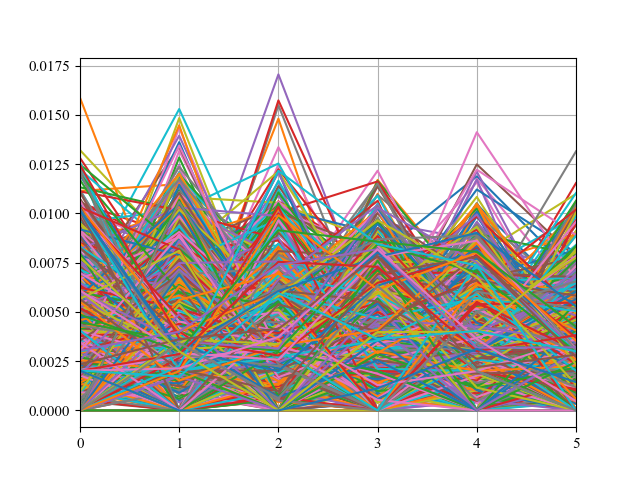

In [14]:
folder_list = glob.glob(os.path.join(folder_path_final_fixed, "*"))

cpu_time_avgs = []
cpu_time_stds = []
cpu_time_all = []
for file_idx in range(len(folder_list)):
    csv_list = glob.glob(os.path.join(folder_list[file_idx], "*.csv"))

    dfs = load_dataframes_from_folder(folder_list[file_idx])
    print(f"Loaded {len(dfs)} DataFrames from {folder_list[file_idx]}.") 
    dataset_exp = Dataset(dfs=dfs, seq_len=H)
    dataloader = DataLoader(dataset_exp, batch_size=batch_size)

    df_len = len(dfs)
    rmse = np.zeros(df_len)
    u_full_all = []
    y_full_all = []
    for i in range(df_len):
        u_full, y_full = dataset_exp.get_full_experiment(i)
        u_full, y_full = u_full.to(device), y_full.to(device)
        u_full_all.append(u_full)
        y_full_all.append(y_full)

    u_full_all = torch.stack(u_full_all, dim=0)
    y_full_all = torch.stack(y_full_all, dim=0)
    y_pred_all = torch.zeros_like(y_full_all)
    last_omega = torch.zeros((df_len, H, 1))  
    cpu_time = []

    with torch.no_grad():
        for j in range(y_full_all.shape[1]):
            
            start = time.time()
            # at time instant j
            if j < H:
                input_val = u_full_all[:, :j+1, :]
                input_val[:, :j+1, 4] = last_omega[:,-j-1:,0]
                pred = model(input_val)[:,-1,:]
            else:
                input_val = u_full_all[:,j-H+1:j+1, :]
                input_val[:,:, 4] = last_omega[:,:,0]
                pred = model(input_val)[:,-1,:]
            
            y_pred_all[:,j,0] = pred[:,0]
            last_omega = torch.roll(last_omega, -1, 1)
            last_omega[:,-1,0] = y_pred_all[:,j,0]
            
            cpu_time.append((time.time()-start))
        
        u_full_all, y_full_all, y_pred_all  = reverse_normalization(u_full_all, y_full_all, y_pred_all)
        

        
    cpu_time_avgs.append(np.mean(cpu_time))
    cpu_time_stds.append(np.std(cpu_time))
    cpu_time_all.append(cpu_time)
    for i in range(df_len):
        y_tmp = y_full_all[i,:,:].cpu().numpy()
        y_pred_tmp = y_pred_all[i,:,:].cpu().numpy()

        df = pd.read_csv(csv_list[i])
        df["omega_meta"] = y_pred_tmp
        # df.to_csv(csv_list[i])
        rmse[i] = np.sqrt(((y_tmp-y_pred_tmp)**2).mean())

    print("Average rmse: ", rmse.mean())


plt.figure()
plt.plot(cpu_time_all)
print("average cpu time: ", np.mean(cpu_time_avgs))
print("std cpu time: ", np.mean(cpu_time_stds))


plt.show()






2001
average cpu time:  0.0034080415730791728
std cpu time:  0.00245803928095317
max cpu time:  0.017055273056030273
min cpu time:  0.0


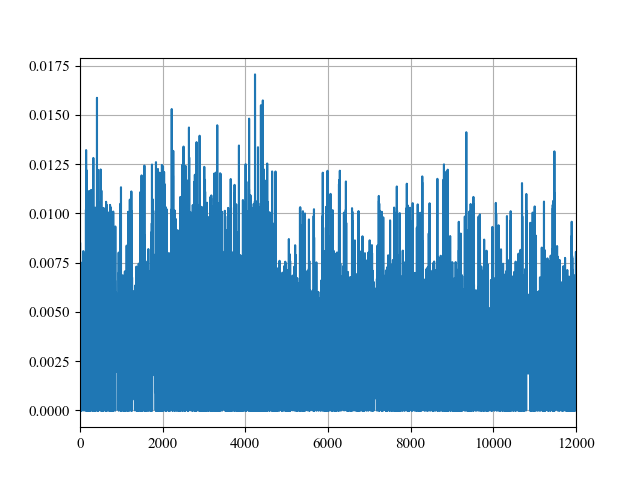

In [15]:
def flatten(xss):
    return [x for xs in xss for x in xs]

print(y_full_all.shape[1])

print("average cpu time: ", np.mean(cpu_time_all))
print("std cpu time: ", np.std(cpu_time_all))
print("max cpu time: ", np.max(cpu_time_all))
print("min cpu time: ", np.min(cpu_time_all))

plt.figure()
list_cpu_time = flatten(cpu_time_all)
plt.plot(list_cpu_time)
plt.show()